# Introduction

On s'intéresse ici à des clusters d'insectes spécifiques pour identifier de potentielles régions endémiques. 
Suite à des erreurs mémoire dues au très grand nombre d'observations à traiter par DBSCAN, nous avons choisi de traiter des genres connus pour être de bons candidats à la recherche de régions endémiques : les genres Bombus et Apis de la famille des Apidae. 

A la différence du notebook intitulé DBSCAN_clustering_et_metrique, ce notebook indexe min_samples (argument de DBSCAN) sur le taux de croissance annuelle des observations depuis 2011 pour la génération de cartes de clusters année par année.

On se sert également des métriques créées pour identifier des clusters d'intérêt.

# Chargement des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import folium
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./spipoll.csv")

C:\Users\guilts0300\AppData\Local\Temp\ipykernel_22084\35506862.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./spipoll.csv")


## Préparation

In [3]:
# Séparation de la colonne 'coordonnées' en deux colonnes 'longitude' et 'latitude'
df[['longitude', 'latitude']] = df['coordonnees_GPS'].str.split(',', expand=True).astype(float)

# Conversion en datetime
df['collection_date'] = pd.to_datetime(df['collection_date'])

# Extraction de l'année à partir de la colonne 'date_observation'
df['annee_collection'] = df['collection_date'].dt.year

In [4]:
unused_columns = ['collection_nom', 'collection_id', 'protocole_long', 'user_id',
       'photo_fleur', 'photo_plante', 'photo_feuille',               
       'plante_caractere', 'plante_inconnue',
       'photo_fleur', 'photo_plante', 'photo_feuille',
       'code_postal', 'fleur_ombre', 
       'insecte_abondance', 'insecte_commentaire', 'insecte_vu_sur_fleur',
        'grande_culture', 'habitat',
        'plante_famille', 'plante_genre', 'plante_espece', 'plante_sc',
       'plante_fr', 'plante_precision', 'collection_date',
       'collection_heure_debut', 'nebulosite', 'temperature', 'vent',   
        'coordonnees_GPS',
       'nb_validation', 'nb_suggestion']

In [5]:
df.drop(columns=unused_columns, inplace=True)

In [6]:
df.columns

Index(['insecte_ordre', 'insecte_super_famille', 'insecte_famille',
       'insecte_sous_famille', 'insecte_genre', 'insecte_espece', 'insecte_sc',
       'insecte_fr', 'insecte_denominationPlusPrecise', 'insecte_CdNomtaxref',
       'longitude', 'latitude', 'annee_collection'],
      dtype='object')

## Filtrage du dataset

In [7]:
df['insecte_famille'].value_counts()

Apidae         85076
Syrphidae      80087
Halictidae     41163
Andrenidae     21857
Nymphalidae    21357
               ...  
Dascillidae       14
Acroceridae        5
Ptinidae           4
Alucitidae         4
Nolidae            1
Name: insecte_famille, Length: 120, dtype: int64

In [8]:
taxon='insecte_famille'

In [9]:
nom=['Apidae', 'Syrphidae']      

In [10]:
data=df.copy()
data = df.where(df[taxon].isin(nom)).dropna(subset=[taxon])
data.drop(columns=['insecte_ordre', 'insecte_super_famille', 'insecte_famille',
       'insecte_sous_famille', 'insecte_espece',
       'insecte_denominationPlusPrecise', 'insecte_CdNomtaxref'], inplace=True)

In [11]:
# Suppression des lignes correspondant avec des années précédant 2011
data = data.drop(data[(data['annee_collection'] < 2011)].index)

# Réinitialiser les index après la suppression des lignes
data = data.reset_index(drop=True)

len(data)


160666

In [12]:
data['insecte_sc'].value_counts()

Bombus                            35864
Apis mellifera                    29328
Eristalis                         21649
Sphaerophoria                      9290
Episyrphus balteatus               7992
Meliscaeva et autres               5119
Syrphus, Dasysyrphus et autres     5037
Apidae et autres                   4936
Syritta                            3893
Eupeodes, Scaeva                   3875
Sphaerophoria scripta              3095
Myathropa florea                   2500
Nomada et autres                   2380
Helophilus, Parhelophilus          2130
Xylocopa                           1897
Anthophora, Eucera                 1576
Eristalinus                        1461
Xylocopa violacea                  1416
Merodon et autres                  1271
Chrysotoxum                        1052
Anthophora et autres               1041
Rhingia                             982
Ceratina cucurbitina                891
Amegilla et autres                  890
Eucera et autres                    790


# Initialisation min_sample 2011

Dans cette section, on indexe min_sample sur le taux de croissance annuelle des observations. On commence par choisir le min_samples intital pour l'année 2011.

In [24]:
data_2011=data.where(data['annee_collection']==2011).dropna(subset='annee_collection')

In [25]:
len(data_2011)

8288

In [26]:
data_2011['insecte_sc'].value_counts()

Bombus                            2078
Apis mellifera                    1513
Eristalis                         1052
Sphaerophoria                      492
Apidae et autres                   462
Episyrphus balteatus               434
Syrphus, Dasysyrphus et autres     280
Syritta                            222
Eupeodes, Scaeva                   208
Meliscaeva et autres               203
Myathropa florea                   143
Xylocopa                           133
Nomada et autres                    91
Anthophora, Eucera                  90
Helophilus, Parhelophilus           68
Merodon et autres                   67
Xylocopa violacea                   62
Chrysotoxum                         61
Sphaerophoria scripta               61
Volucella zonaria                   56
Eristalinus                         50
Rhingia                             47
Amegilla et autres                  41
Eucera et autres                    41
Eristalinus taeniops                34
Ceratina                 

## Affinage de epsilon et min_sample

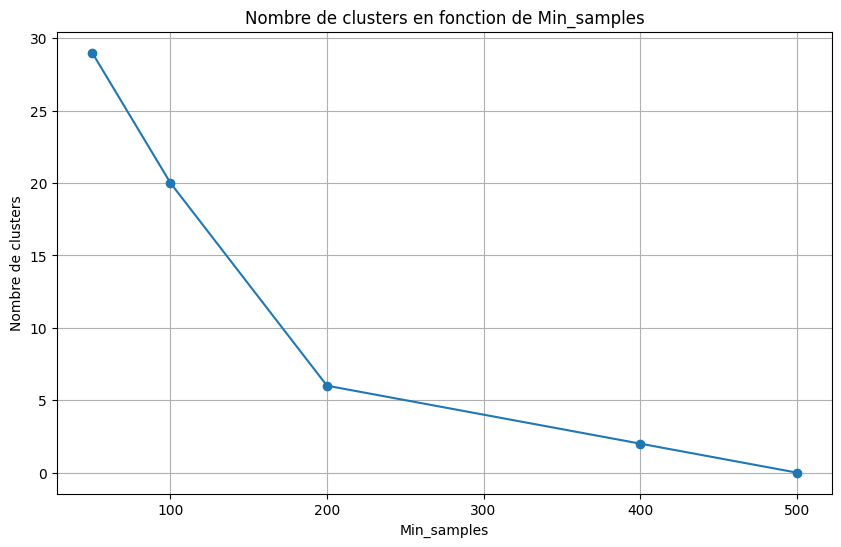

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Plage de valeurs pour min_samples et epsilon
min_samples_range = [50, 100, 200, 400, 500]
epsilon = 0.1

# Nombre de clusters pour chaque valeur de min_samples
num_clusters = []

# Analyse pour chaque valeur de min_samples
for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(data_2011[['latitude', 'longitude']])
    num_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))  # Ignorer les points considérés comme du bruit

# Graphique
plt.figure(figsize=(10, 6))
plt.plot(min_samples_range, num_clusters, marker='o')
plt.xlabel('Min_samples')
plt.ylabel('Nombre de clusters')
plt.title('Nombre de clusters en fonction de Min_samples')
plt.grid(True)
plt.show()


On retient donc min_samples= 200 (cassure du graph). On observe qu'avec min_samples=500, on avait bien 0 cluster.

# DBSCAN

In [54]:
# Dataset avec uniquement les coordonnées GPS
coordonnees_gps = data[['latitude', 'longitude']]

# Instanc et entraînement du modèle DBSCAN
epsilon = 0.1  # Rayon maximal pour considérer les points voisins
min_samples = 200  # Nombre minimal de points dans un cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(coordonnees_gps)

# Ajout des labels de cluster au DataFrame d'origine
data['cluster_label'] = dbscan.labels_

# Filtrage des données pour exclure les points considérés comme du bruit (cluster_label = -1)
df_clusters = data[data['cluster_label'] != -1]

# Calcul des latitudes et longitudes moyennes de chaque cluster
cluster_coords = df_clusters.groupby('cluster_label').agg({'latitude': 'mean', 'longitude': 'mean'})

# Calcul du nombre total d'insectes par cluster
total_insectes_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].count()

# Calcul de la proportion de chaque type d'insecte par cluster
proportion_par_cluster = df_clusters.groupby(['cluster_label', 'insecte_fr']).size() / total_insectes_par_cluster
proportion_par_cluster = proportion_par_cluster.reset_index(name='proportion')

# Affichage des régions endémiques avec la proportion de chaque type d'insecte
regions = proportion_par_cluster.pivot(index='cluster_label', columns='insecte_fr', values='proportion').fillna(0)

# Ajout des coordonnées de chaque cluster au DataFrame des régions endémiques
regions[['latitude', 'longitude']] = cluster_coords

# Ajout du nombre d'insectes par clusters
regions['nb_insectes'] = total_insectes_par_cluster

print("Nombre de clusters : ", len(regions))

# Trouver l'insecte le plus abondant dans chaque cluster
insecte_majoritaire_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].agg(lambda x: x.value_counts().index[0])

# Calcul de la proportion de l'insecte majoritaire dans chaque cluster
proportion_insecte_majoritaire_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].apply(lambda x: (x == x.mode()[0]).mean())


Nombre de clusters :  80


# Carte 

In [55]:
# Fonction pour attribuer une couleur à chaque insecte pour les marqueurs sur les cartes folium
def assigner_couleur(insecte):
    if insecte == "L'Abeille mellifère":
        return 'darkred'
    elif insecte == 'Les Bourdons noirs à bande(s) jaune(s) et cul blanc':
        return 'lightred'
    elif insecte == 'Les Eristales (autres)':
        return 'green'
    #elif insecte == 'Les Bourdons noirs à bande(s) jaune(s) et cul rouge':
        #return 'lightgreen'
    else : 
        return 'blue'

In [56]:
# Coordonnées géographiques de Paris pour centrer la carte
paris_latitude = 48.8566
paris_longitude = 2.3522

# Création de la carte Folium centrée sur Paris
carte = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=5)

# Ajout des marqueurs pour chaque cluster
for index, row in cluster_coords.iterrows():
    insecte_majoritaire = insecte_majoritaire_par_cluster.loc[index]
    proportion_insecte_majoritaire = proportion_insecte_majoritaire_par_cluster.loc[index]
    nombre_d_insectes = total_insectes_par_cluster.loc[index]
    
    # Taille du marqueur proportionnelle au nombre d'insectes
    taille_marqueur = nombre_d_insectes / 10
    
    # Couleur du marqueur
    couleur_marqueur = assigner_couleur(insecte_majoritaire)
    
    # Créer le texte de la popup
    popup_text = f"Cluster {index} de {insecte_majoritaire}: Nombre d'insectes total = {nombre_d_insectes}, Proportion de {insecte_majoritaire} = {proportion_insecte_majoritaire:.2f}"
    
    # Ajout du marqueur à la carte
    folium.Marker([row['longitude'], row['latitude']], popup=popup_text, icon=folium.Icon(color=couleur_marqueur), 
                  radius=taille_marqueur).add_to(carte)

# Affichage de la carte
carte.save('carte_clusters_apidae_syrphidae_minSamp200.html')

In [57]:
carte

# Métriques d'évaluation

Mesurer la représentativité d'un cluster en tant que région endémique peut être un défi complexe, car cela nécessite de considérer plusieurs facteurs et caractéristiques à la fois spatiales et écologiques. On crée donc des métriques pour pouvoir analyser et identifier plus facilement des clusters d'attention.

1. **Densité de points** :
   - Utilisation de techniques de densité de noyaux (kernel density estimation) pour calculer la densité de points à l'intérieur de chaque cluster. Cela permettra d'obtenir une estimation de la densité de points par unité de surface dans chaque cluster.

2. **Variété d'espèces** :
   - Utilisation d'indices de diversité écologique tels que l'indice de Shannon-Wiener ou l'indice de Simpson pour évaluer la diversité des espèces présentes dans chaque cluster. Ces indices prennent en compte à la fois la richesse en espèces et l'équitabilité de leur distribution.

3. **Endémisme spécifique**:
   - Il pourrait être intéressant d'analyser les espèces endémiques présentes dans chaque cluster en comparant la liste des espèces dans le cluster avec une liste d'espèces connues pour être endémiques à la région d'intérêt. On pourrait alors calculer un indice d'endémisme spécifique pour chaque cluster en fonction du nombre et de la rareté des espèces endémiques qu'il contient.

4. **Stabilité temporelle** :
   - On aurait aimé utilisé des méthodes d'analyse de série chronologique pour évaluer la persistance des clusters dans différentes périodes de temps, notamment à l'aide de ST-DBSCAN, que nous n'avons pas réussi à installer. On pourrait également comparer la taille et la forme des clusters dans des périodes temporelles différentes pour identifier les clusters qui persistent sur le long terme.
   - A la place, on calcule pour la durée sur laquellele cluster perdure et la date de la dernière observation.
   - On filtre le dataset année par année puis on relance DBSCAN pour chacun des sous-datasets pour décomposer les clusters dans le temps et observer une potentielle évolution de ces derniers.

5. **Isolation géographique** :
   - Les clusters situés dans des zones géographiquement isolées peuvent être considérés comme plus importants pour la conservation. On peut calculer la distince au cluster le plus proche ou calculer des mesures d'isolation géographique pour chaque cluster, telles que la distance aux clusters voisins ou l'indice de Moran's I pour évaluer la spatialité des clusters.


Ultimement, on pourrait pondérer et agréger ces mesures pour combiner ces mesures en une seule métrique de représentativité. 

## Densité des clusters 

In [58]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

data2=data.copy()
data2.drop(columns='annee_collection', inplace=True)
# Création des géométries ponctuelles à partir des colonnes de latitude et de longitude
geometry = [Point(xy) for xy in zip(data2.longitude, data2.latitude)]

# Création d'un GeoDataFrame à partir des données et des géométries
gdf = gpd.GeoDataFrame(data2, geometry=geometry)

# Définition du système de coordonnées de référence (CRS) si nécessaire
gdf.crs = "EPSG:4326"  # Par exemple, WGS 84

# Enregistrement du GeoDataFrame dans un fichier
gdf.to_file("clusters_gdf.shp")  # au format Shapefile


C:\Users\guilts0300\AppData\Local\Temp\ipykernel_22084\3732293045.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("clusters_gdf.shp")  # Enregistrez les données au format Shapefile


In [59]:
from sklearn.neighbors import KernelDensity

# Calcul des centres des clusters en utilisant la moyenne des coordonnées
cluster_centers = df_clusters.groupby('cluster_label').agg({'latitude': 'mean', 'longitude': 'mean'})

# Tableau Numpy des coordonnées des centres des clusters
cluster_coordinates = cluster_centers.values

# Modèle de densité de noyaux avec Scikit-learn
bandwidth = 0.1  # A régler selon les besoins
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')

# Adaptation du modèle aux coordonnées des centres des clusters
kde.fit(cluster_coordinates)

# Évaluation de la densité de points pour chaque centre de cluster
densities = np.exp(kde.score_samples(cluster_coordinates))

# Ajout des densités calculées au DataFrame des clusters
cluster_centers['densite_cluster'] = densities

regions['densite_cluster']=densities
regions

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,Les Syrphes aux fémurs enflés,Les Syrphes difficiles à déterminer,Les Syrphes à abdomen fin,Les Syrphes à l'aspect de bourdon,Les Syrphes à taches en virgules,Les Xylocopes,latitude,longitude,nb_insectes,densite_cluster
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.002936,0.000206,0.186988,0.019987,0.000052,0.000927,0.000515,0.0,0.000000,0.000000,...,0.004121,0.036883,0.030495,0.008551,0.034925,0.005306,2.162707,48.879697,19413,0.198944
1,0.012929,0.000369,0.296269,0.018840,0.017362,0.000000,0.000369,0.0,0.000000,0.001108,...,0.001478,0.017362,0.028814,0.003694,0.024381,0.025120,5.932064,43.213971,2707,0.198944
2,0.001209,0.000097,0.145468,0.014938,0.000000,0.000048,0.000338,0.0,0.000000,0.000048,...,0.008557,0.042930,0.035098,0.008219,0.015422,0.003094,-1.670731,48.201147,20685,0.198944
3,0.015085,0.000000,0.219712,0.012897,0.000469,0.000078,0.003595,0.0,0.000000,0.001563,...,0.002501,0.050102,0.030483,0.006175,0.023527,0.025012,4.576260,44.705483,12794,0.199289
4,0.003437,0.000000,0.217690,0.021311,0.004354,0.000000,0.000229,0.0,0.000000,0.001146,...,0.008937,0.027498,0.028185,0.007333,0.014436,0.043767,4.388067,43.963736,4364,0.198944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.004324,0.000000,0.120000,0.007568,0.006486,0.000000,0.002162,0.0,0.000000,0.000000,...,0.002162,0.020541,0.036757,0.000000,0.015135,0.017297,0.206781,43.555433,925,0.198944
76,0.004950,0.000000,0.202970,0.004950,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.009901,0.004950,0.019802,0.000000,0.024752,0.004950,-0.977386,45.990220,202,0.204671
77,0.000000,0.000000,0.026087,0.008696,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.004348,0.026087,0.000000,0.021739,0.021739,0.000000,2.859526,45.364054,230,0.198978


## Variétés d'espèces

In [60]:
regions.iloc[:, :54]

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,Les Syrphes Sphaerophoria (femelle),Les Syrphes Sphaerophoria (mâle),Les Syrphes Syrphus et autres,Les Syrphes aux antennes à bout blanc,Les Syrphes aux fémurs enflés,Les Syrphes difficiles à déterminer,Les Syrphes à abdomen fin,Les Syrphes à l'aspect de bourdon,Les Syrphes à taches en virgules,Les Xylocopes
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.002936,0.000206,0.186988,0.019987,0.000052,0.000927,0.000515,0.0,0.000000,0.000000,...,0.047133,0.019626,0.033792,0.000412,0.004121,0.036883,0.030495,0.008551,0.034925,0.005306
1,0.012929,0.000369,0.296269,0.018840,0.017362,0.000000,0.000369,0.0,0.000000,0.001108,...,0.031400,0.008127,0.013299,0.000000,0.001478,0.017362,0.028814,0.003694,0.024381,0.025120
2,0.001209,0.000097,0.145468,0.014938,0.000000,0.000048,0.000338,0.0,0.000000,0.000048,...,0.025574,0.012666,0.030022,0.000000,0.008557,0.042930,0.035098,0.008219,0.015422,0.003094
3,0.015085,0.000000,0.219712,0.012897,0.000469,0.000078,0.003595,0.0,0.000000,0.001563,...,0.046741,0.020947,0.023761,0.000703,0.002501,0.050102,0.030483,0.006175,0.023527,0.025012
4,0.003437,0.000000,0.217690,0.021311,0.004354,0.000000,0.000229,0.0,0.000000,0.001146,...,0.036893,0.011916,0.022686,0.000229,0.008937,0.027498,0.028185,0.007333,0.014436,0.043767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.004324,0.000000,0.120000,0.007568,0.006486,0.000000,0.002162,0.0,0.000000,0.000000,...,0.077838,0.031351,0.022703,0.000000,0.002162,0.020541,0.036757,0.000000,0.015135,0.017297
76,0.004950,0.000000,0.202970,0.004950,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.039604,0.019802,0.029703,0.000000,0.009901,0.004950,0.019802,0.000000,0.024752,0.004950
77,0.000000,0.000000,0.026087,0.008696,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.043478,0.030435,0.008696,0.000000,0.004348,0.026087,0.000000,0.021739,0.021739,0.000000


In [61]:
# Les 54 premières colonnes du dataset regions correspondent aux proportions d'insectes
colonnes_proportions=54

In [62]:
# Fonction pour le calcul de l'indice de Shannon-Wiener pour chaque cluster
def shannon_index(proportions):
    return -np.sum(proportions * np.log(proportions + 1e-10))  # Ajout de 1e-10 pour éviter les erreurs de division par zéro

# Fonction pour le calcul de l'indice de Simpson pour chaque cluster
def simpson_index(proportions):
    return 1 - np.sum(proportions ** 2)

# Calcul de l'indice de Shannon-Wiener pour chaque cluster
regions['shannon_index'] = regions.iloc[:, :colonnes_proportions].apply(shannon_index, axis=1)  # Supposant que les colonnes 0 à 7 contiennent les proportions des insectes

# Calcul de l'indice de Simpson pour chaque cluster
regions['simpson_index'] = regions.iloc[:, :colonnes_proportions].apply(simpson_index, axis=1)  # Supposant que les colonnes 0 à 7 contiennent les proportions des insectes

# Affichage des indices de Shannon-Wiener et de Simpson pour chaque cluster
regions[['shannon_index', 'simpson_index']]


insecte_fr,shannon_index,simpson_index
cluster_label,,
0,2.980365,0.924256
1,2.752141,0.877539
2,2.870705,0.910673
3,3.010152,0.915528
4,3.001460,0.918203
...,...,...
75,2.891965,0.920908
76,2.609856,0.889374
77,2.312372,0.812892


Interprétations des indices : 

- Indice de Shannon-Wiener :

Plus l'indice de Shannon-Wiener est élevé, plus la diversité des espèces dans le cluster est grande.
Cela signifie qu'il y a une grande variété d'espèces présentes dans le cluster, et que leur abondance est relativement uniforme.
Un indice de Shannon-Wiener proche de zéro indique une faible diversité des espèces, ce qui peut être dû à la dominance d'une ou de quelques espèces dans le cluster.

- Indice de Simpson : L'indice de Simpson est un indice permettant de mesurer la diversité d'un milieu, créé par Edward Simpson en 1949, en calculant la probabilité que deux individus sélectionnés au hasard appartiennent à la même espèce. 

Un indice de Simpson proche de 1 indique une faible diversité des espèces et donc une forte dominance d'une ou de quelques espèces dans le cluster.
Plus l'indice de Simpson est proche de zéro, plus la diversité des espèces est élevée, car les espèces sont plus équitablement réparties dans le cluster.
Ainsi, un indice de Simpson faible indique une grande diversité des espèces dans le cluster, avec une répartition plus uniforme des abondances des espèces.
En résumé, ces indices permettent d'évaluer la diversité des espèces dans un cluster en prenant en compte à la fois le nombre d'espèces présentes et la répartition relative de leur abondance. Ils fournissent des informations précieuses sur la structure et la composition de la communauté d'espèces dans un cluster donné. Une interprétation approfondie nécessiterait de comparer ces indices entre différents clusters ou à des échantillons de référence pour évaluer la santé et la biodiversité de l'écosystème étudié.

## Isolation géographique

In [63]:
# Calcul de la distance en km séparant 2 clusters les plus proches

from math import radians, sin, cos, sqrt, atan2

# Fonction pour calculer la distance en kilomètres entre deux points en utilisant la formule de Haversine
def distance_haversine(lat1, lon1, lat2, lon2):
    # Convertir les coordonnées de degrés en radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Rayon moyen de la Terre en kilomètres
    R = 6371.0

    # Calcul des différences de latitude et de longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calcul de la distance géodésique en utilisant la formule de Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance


# Nouvelle colonne pour stocker les distances vers le cluster le plus proche
regions['km_du_cluster_le_plus_proche'] = 0.0

# Pour chaque cluster
for i, row in regions.iterrows():
    lat1, lon1 = row['latitude'], row['longitude']
    min_distance = float('inf')  # Initialisation avec une valeur infinie pour trouver la distance minimale

    # Calcul de la distance vers chaque autre cluster
    for j, other_row in regions.iterrows():
        if i != j:  # Pour éviter de calculer la distance à lui-même
            lat2, lon2 = other_row['latitude'], other_row['longitude']
            distance = distance_haversine(lat1, lon1, lat2, lon2)
            min_distance = min(min_distance, distance)  # Mise à jour la distance minimale
    
    # On assigne la distance minimale au cluster le plus proche
    regions.at[i, 'km_du_cluster_le_plus_proche'] = min_distance

# Affichage du dataset mis à jour
regions

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,Les Syrphes à l'aspect de bourdon,Les Syrphes à taches en virgules,Les Xylocopes,latitude,longitude,nb_insectes,densite_cluster,shannon_index,simpson_index,km_du_cluster_le_plus_proche
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.002936,0.000206,0.186988,0.019987,0.000052,0.000927,0.000515,0.0,0.000000,0.000000,...,0.008551,0.034925,0.005306,2.162707,48.879697,19413,0.198944,2.980365,0.924256,71.764288
1,0.012929,0.000369,0.296269,0.018840,0.017362,0.000000,0.000369,0.0,0.000000,0.001108,...,0.003694,0.024381,0.025120,5.932064,43.213971,2707,0.198944,2.752141,0.877539,64.117485
2,0.001209,0.000097,0.145468,0.014938,0.000000,0.000048,0.000338,0.0,0.000000,0.000048,...,0.008219,0.015422,0.003094,-1.670731,48.201147,20685,0.198944,2.870705,0.910673,61.117843
3,0.015085,0.000000,0.219712,0.012897,0.000469,0.000078,0.003595,0.0,0.000000,0.001563,...,0.006175,0.023527,0.025012,4.576260,44.705483,12794,0.199289,3.010152,0.915528,39.525054
4,0.003437,0.000000,0.217690,0.021311,0.004354,0.000000,0.000229,0.0,0.000000,0.001146,...,0.007333,0.014436,0.043767,4.388067,43.963736,4364,0.198944,3.001460,0.918203,65.572043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.004324,0.000000,0.120000,0.007568,0.006486,0.000000,0.002162,0.0,0.000000,0.000000,...,0.000000,0.015135,0.017297,0.206781,43.555433,925,0.198944,2.891965,0.920908,77.416977
76,0.004950,0.000000,0.202970,0.004950,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.024752,0.004950,-0.977386,45.990220,202,0.204671,2.609856,0.889374,29.618851
77,0.000000,0.000000,0.026087,0.008696,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.021739,0.021739,0.000000,2.859526,45.364054,230,0.198978,2.312372,0.812892,46.210046


## Stabilité temporelle

On aurait aimé utiliser ST-DBSCAN mais problème d'installation rencontré. On aurait également souhaité utiliser l'API de arcgis Pro qui permet d'évaluer les clusters dans le temps mais cette dernière nécessite un compte officiel Arcgis ou trop d'informations personnelles pour une version gratuite et l'obtention d'une clé.
A la place de ST-DBSCAN, on décide par ailleurs de générer des cartes années par années pour visualiser l'évolution des clusters.

In [64]:
# Conversion de la colonne de date en format datetime
#data['date_observation'] = pd.to_datetime(data['date_observation'])

# Calcul de la stabilité temporelle pour chaque cluster
cluster_stability = df_clusters.groupby('cluster_label').apply(lambda x: x['annee_collection'].max() - x['annee_collection'].min())

# Calcul de la dernière année observée pour chaque cluster
last_obs_year = df_clusters.groupby('cluster_label')['annee_collection'].max()

# Résultats
regions['cluster_stability'] = cluster_stability
regions['last_obs_year'] = last_obs_year
regions

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,Les Xylocopes,latitude,longitude,nb_insectes,densite_cluster,shannon_index,simpson_index,km_du_cluster_le_plus_proche,cluster_stability,last_obs_year
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.002936,0.000206,0.186988,0.019987,0.000052,0.000927,0.000515,0.0,0.000000,0.000000,...,0.005306,2.162707,48.879697,19413,0.198944,2.980365,0.924256,71.764288,12.0,2023.0
1,0.012929,0.000369,0.296269,0.018840,0.017362,0.000000,0.000369,0.0,0.000000,0.001108,...,0.025120,5.932064,43.213971,2707,0.198944,2.752141,0.877539,64.117485,12.0,2023.0
2,0.001209,0.000097,0.145468,0.014938,0.000000,0.000048,0.000338,0.0,0.000000,0.000048,...,0.003094,-1.670731,48.201147,20685,0.198944,2.870705,0.910673,61.117843,12.0,2023.0
3,0.015085,0.000000,0.219712,0.012897,0.000469,0.000078,0.003595,0.0,0.000000,0.001563,...,0.025012,4.576260,44.705483,12794,0.199289,3.010152,0.915528,39.525054,12.0,2023.0
4,0.003437,0.000000,0.217690,0.021311,0.004354,0.000000,0.000229,0.0,0.000000,0.001146,...,0.043767,4.388067,43.963736,4364,0.198944,3.001460,0.918203,65.572043,12.0,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.004324,0.000000,0.120000,0.007568,0.006486,0.000000,0.002162,0.0,0.000000,0.000000,...,0.017297,0.206781,43.555433,925,0.198944,2.891965,0.920908,77.416977,3.0,2023.0
76,0.004950,0.000000,0.202970,0.004950,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.004950,-0.977386,45.990220,202,0.204671,2.609856,0.889374,29.618851,12.0,2023.0
77,0.000000,0.000000,0.026087,0.008696,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,2.859526,45.364054,230,0.198978,2.312372,0.812892,46.210046,2.0,2023.0


#### Génération cartes annuelles

##### Préparation des données 

In [41]:
data.drop(columns=['cluster_label'], inplace=True)

In [42]:
data

,insecte_genre,insecte_sc,insecte_fr,longitude,latitude,annee_collection
0,Apis,Apis mellifera,L'Abeille mellifère,45.363808,6.514947,2019.0
1,Bombus,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,45.363808,6.514947,2019.0
2,Bombus,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,48.844975,2.358313,2019.0
3,Apis,Apis mellifera,L'Abeille mellifère,48.844975,2.358313,2019.0
4,Apis,Apis mellifera,L'Abeille mellifère,47.679478,-3.183325,2019.0
...,...,...,...,...,...,...
160661,Eristalis,Eristalis,Les Eristales (autres),44.712529,4.568813,2023.0
160662,Sphaerophoria,Sphaerophoria,Les Syrphes Sphaerophoria (femelle),44.712529,4.568813,2023.0
160663,Eristalis,Eristalis,Les Eristales (autres),44.712618,4.568999,2023.0
160664,Bombus,Bombus,Les Bourdons à pilosité fauve à grise,44.712618,4.568999,2023.0


In [43]:
# Comptage du nombre d'observations par année
observations_par_annee = data['annee_collection'].value_counts()

observations_par_annee

2021.0    18812
2020.0    17604
2019.0    13582
2022.0    13402
2023.0    12826
2016.0    12669
2013.0    11989
2018.0    11618
2015.0    11356
2017.0    10948
2014.0     9367
2011.0     8288
2012.0     8205
Name: annee_collection, dtype: int64

In [44]:
data.to_csv('data_clustering_et_metrique.csv', index=False) 

##### Relance de l'analyse avec DBSCAN

In [45]:
# Fonction pour attribuer une couleur à chaque insecte pour les marqueurs des cartes folium
def assigner_couleur(insecte):
    if insecte == "L'Abeille mellifère":
        return 'darkred'
    elif insecte == 'Les Bourdons noirs à bande(s) jaune(s) et cul blanc':
        return 'lightred'
    elif insecte == 'Les Eristales (autres)':
        return 'green'
    #elif insecte == 'Les Bourdons noirs à bande(s) jaune(s) et cul rouge':
        #return 'lightgreen'
    else : 
        return 'blue'

In [48]:
from sklearn.cluster import DBSCAN
import pandas as pd
import folium

data = pd.read_csv("./data_clustering_et_metrique.csv")  

# On colle ci-dessous la liste de min_samples indexés obtenue dans le notebook Active_Users_per_year
min_samples_list_200 = [200, 213, 279, 166, 261, 208, 212, 193, 247, 236, 206, 164, 183]

# Itération sur les années et les valeurs de min_samples simultanément
for annee, min_samples in zip(data['annee_collection'].unique(), min_samples_list_200):
    
    # Filtrage des données pour l'année spécifique
    data_annee = data[data['annee_collection'] == annee]
    
    # DataFrame avec uniquement les coordonnées GPS
    coordonnees_gps = data_annee[['latitude', 'longitude']]

    # Instance et entraînement du modèle DBSCAN
    epsilon = 0.1  # Rayon maximal pour considérer les points voisins
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(coordonnees_gps)

    # Ajout des labels de cluster au DataFrame d'origine
    data_annee['cluster_label'] = dbscan.labels_

    # Filtrage des données pour exclure les points considérés comme du bruit (cluster_label = -1)
    df_clusters = data_annee[data_annee['cluster_label'] != -1]

    # Calcul de la latitude et la longitude moyennes de chaque cluster
    cluster_coords = df_clusters.groupby('cluster_label').agg({'latitude': 'mean', 'longitude': 'mean'})

    # Calcul du nombre total d'insectes par cluster
    total_insectes_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].count()

    # Calcul de la proportion de chaque type d'insecte par cluster
    proportion_par_cluster = df_clusters.groupby(['cluster_label', 'insecte_fr']).size() / total_insectes_par_cluster
    proportion_par_cluster = proportion_par_cluster.reset_index(name='proportion')

    # Affichage des régions endémiques avec la proportion de chaque type d'insecte
    regions = proportion_par_cluster.pivot(index='cluster_label', columns='insecte_fr', values='proportion').fillna(0)

    # Ajout des coordonnées de chaque cluster au DataFrame des régions endémiques
    regions[['latitude', 'longitude']] = cluster_coords

    # Ajout du nombre d'insectes par clusters
    regions['nb_insectes'] = total_insectes_par_cluster

    # Trouver l'insecte le plus abondant dans chaque cluster
    insecte_majoritaire_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].agg(lambda x: x.value_counts().index[0])

    # Calcul de la proportion de l'insecte majoritaire dans chaque cluster
    proportion_insecte_majoritaire_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].apply(lambda x: (x == x.mode()[0]).mean())

    # Coordonnées géographiques de Paris pour centrer la carte
    paris_latitude = 48.8566
    paris_longitude = 2.3522

    # Création de la carte Folium centrée sur Paris pour pouvoir comparer plus facilement les cartes entre elles
    carte = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=5)

    # Ajout des marqueurs pour chaque cluster
    for index, row in cluster_coords.iterrows():
        insecte_majoritaire = insecte_majoritaire_par_cluster.loc[index]
        proportion_insecte_majoritaire = proportion_insecte_majoritaire_par_cluster.loc[index]
        nombre_d_insectes = total_insectes_par_cluster.loc[index]

        # Taille du marqueur proportionnelle au nombre d'insectes
        taille_marqueur = nombre_d_insectes / 10

        # Couleur du marqueur
        couleur_marqueur = assigner_couleur(insecte_majoritaire)

        # Texte de la popup
        popup_text = f"Cluster {index} de {insecte_majoritaire}: Nombre d'insectes total = {nombre_d_insectes}, Proportion de {insecte_majoritaire} = {proportion_insecte_majoritaire:.2f}"

        # Ajout du marqueur à la carte
        folium.Marker([row['longitude'], row['latitude']], popup=popup_text, icon=folium.Icon(color=couleur_marqueur), 
                      radius=taille_marqueur).add_to(carte)

    # Sauvegarde de la carte pour cette année dans le répertoire spécifique
    carte.save(f'./cartes_clustering_adjustedBase200/carte_clusters_apidae_syrphidae{annee}_adjustedBase200.html')

C:\Users\guilts0300\AppData\Local\Temp\ipykernel_22084\2404111326.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_annee['cluster_label'] = dbscan.labels_
C:\Users\guilts0300\AppData\Local\Temp\ipykernel_22084\2404111326.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_annee['cluster_label'] = dbscan.labels_
C:\Users\guilts0300\AppData\Local\Temp\ipykernel_22084\2404111326.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [49]:
# On souhaite ici enregistrer les cartes folium au format PNG après en avoir pris une capture d'écran. On aurait voulu créer ensuite une animation GIF pour 
# faire défiler les cartes année par année. 

import os
import imageio
from selenium import webdriver
import os

# Répertoire contenant les cartes Folium
repertoire_cartes = './cartes_clustering_adjustedBase200'

# Liste pour stocker les chemins des fichiers des cartes Folium
chemins_cartes = []

# Récupération des chemins des fichiers des cartes Folium
for fichier in os.listdir(repertoire_cartes):
    if fichier.endswith('.html'):
        chemin_fichier = os.path.join(repertoire_cartes, fichier)
        chemins_cartes.append(chemin_fichier)

# Tri des chemins des fichiers par ordre alphabétique pour garantir l'ordre chronologique
chemins_cartes.sort()

# Liste pour stocker les images des cartes
images = []

# Conversion des cartes en images
for chemin_carte in chemins_cartes:
    # Ouvrir le fichier HTML et le lire en tant que texte brut
    with open(chemin_carte, 'r') as f:
        html_content = f.read()

        # Création d'un répertoire pour sauvegarder les images temporaires
        os.makedirs('images_temp', exist_ok=True)

        # Configuration du navigateur
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')  # Pour exécuter Chrome en mode headless (sans interface graphique)
        driver = webdriver.Chrome(options=options)
        
        # Parcours des fichiers HTML des cartes Folium et prise des captures d'écran
        for chemin_carte in chemins_cartes:
            # Charger le fichier HTML dans le navigateur
            driver.get('file:///' + os.path.abspath(chemin_carte))

            # Capture d'écran et sauvegarde de l'image
            image_name = os.path.basename(chemin_carte)[:-5] + '.png'  # Nom de l'image basé sur le nom du fichier HTML
            image_path = os.path.join('cartes_clustering_adjustedBase200', image_name)  # Chemin complet pour enregistrer l'image
            driver.save_screenshot(image_path)

            # Ajout du le chemin de l'image à la liste des images
            images.append(image_path)

# On ferme le navigateur
driver.quit()

## Analyse à partir des métriques

Dans cette section, on utilise les métriques créées pour identifier des clusters d'intérêt. On cherche par exemple des clusters en potentielle déplétion ou au contraire des clusters riches en espèces et qui perdurent dans le temps.

In [65]:
regions

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,Les Xylocopes,latitude,longitude,nb_insectes,densite_cluster,shannon_index,simpson_index,km_du_cluster_le_plus_proche,cluster_stability,last_obs_year
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.002936,0.000206,0.186988,0.019987,0.000052,0.000927,0.000515,0.0,0.000000,0.000000,...,0.005306,2.162707,48.879697,19413,0.198944,2.980365,0.924256,71.764288,12.0,2023.0
1,0.012929,0.000369,0.296269,0.018840,0.017362,0.000000,0.000369,0.0,0.000000,0.001108,...,0.025120,5.932064,43.213971,2707,0.198944,2.752141,0.877539,64.117485,12.0,2023.0
2,0.001209,0.000097,0.145468,0.014938,0.000000,0.000048,0.000338,0.0,0.000000,0.000048,...,0.003094,-1.670731,48.201147,20685,0.198944,2.870705,0.910673,61.117843,12.0,2023.0
3,0.015085,0.000000,0.219712,0.012897,0.000469,0.000078,0.003595,0.0,0.000000,0.001563,...,0.025012,4.576260,44.705483,12794,0.199289,3.010152,0.915528,39.525054,12.0,2023.0
4,0.003437,0.000000,0.217690,0.021311,0.004354,0.000000,0.000229,0.0,0.000000,0.001146,...,0.043767,4.388067,43.963736,4364,0.198944,3.001460,0.918203,65.572043,12.0,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.004324,0.000000,0.120000,0.007568,0.006486,0.000000,0.002162,0.0,0.000000,0.000000,...,0.017297,0.206781,43.555433,925,0.198944,2.891965,0.920908,77.416977,3.0,2023.0
76,0.004950,0.000000,0.202970,0.004950,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.004950,-0.977386,45.990220,202,0.204671,2.609856,0.889374,29.618851,12.0,2023.0
77,0.000000,0.000000,0.026087,0.008696,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,2.859526,45.364054,230,0.198978,2.312372,0.812892,46.210046,2.0,2023.0


In [66]:
regions.describe()

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,Les Xylocopes,latitude,longitude,nb_insectes,densite_cluster,shannon_index,simpson_index,km_du_cluster_le_plus_proche,cluster_stability,last_obs_year
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.004707,0.000139,0.178770,0.013479,0.001622,0.000491,0.000668,0.000010,0.000083,0.000546,...,0.010891,2.666869,46.300752,1711.562500,0.200026,2.822396,0.905783,59.022815,10.487500,2022.475000
std,0.005888,0.000573,0.068656,0.009226,0.004273,0.001271,0.001532,0.000092,0.000552,0.001664,...,0.011036,3.006200,2.138972,3484.244534,0.002538,0.178673,0.025385,26.429333,2.737428,1.492386
min,0.000000,0.000000,0.026087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-4.268411,42.474463,202.000000,0.198944,2.312372,0.812892,26.595028,0.000000,2014.000000
25%,0.000000,0.000000,0.134859,0.005613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003564,0.279263,44.632387,269.500000,0.198944,2.714782,0.897657,40.462721,10.000000,2023.000000
50%,0.002881,0.000000,0.163927,0.012893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007185,2.947116,46.066929,580.000000,0.198945,2.853462,0.912925,53.845975,12.000000,2023.000000
75%,0.007426,0.000000,0.217646,0.017950,0.000000,0.000056,0.000365,0.000000,0.000000,0.000000,...,0.014749,5.373519,47.912457,1409.750000,0.199246,2.935995,0.922497,71.123700,12.000000,2023.000000
max,0.028272,0.003425,0.362360,0.050290,0.022364,0.007018,0.008264,0.000824,0.004878,0.010667,...,0.050676,7.667764,50.673205,20685.000000,0.210333,3.194752,0.940712,164.560326,12.000000,2023.000000


In [67]:
# On affiche les 5 clusters ayant l'index Shannon le plus élevé
regions['shannon_index'].nlargest(5)

cluster_label
32    3.194752
31    3.130911
73    3.085150
20    3.074832
8     3.063701
Name: shannon_index, dtype: float64

In [68]:
# On affiche les 5 clusters ayant l'index Simpson le plus élevé
regions['simpson_index'].nlargest(5)

cluster_label
73    0.940712
37    0.936657
31    0.935806
32    0.935616
42    0.932354
Name: simpson_index, dtype: float64

In [77]:
# On affiche les 5 clusters ayant les index Shannon et Simpson les plus élevés (scores obtenus en combinant les deux par la somme)
regions['combinaison'] = regions['shannon_index'] + regions['simpson_index']

regions['combinaison'].nlargest(10)

cluster_label
32    4.130368
31    4.066717
73    4.025862
20    4.002262
8     3.993542
5     3.983249
58    3.978634
54    3.975922
42    3.962595
13    3.930263
Name: combinaison, dtype: float64

In [78]:
# Clusters ayant le moins perduré dans le temps
regions['cluster_stability'].nsmallest(10)

cluster_label
78    0.0
77    2.0
67    3.0
74    3.0
75    3.0
65    4.0
18    5.0
15    6.0
53    7.0
31    8.0
Name: cluster_stability, dtype: float64

In [76]:
# On crée une liste des clusters ayant le moins perduré dans le temps pour les étudier davantage 
cluster_label_list = [78, 77, 67,74,75]

# Méthode .index.isin() pour vérifier si les index des lignes sont dans la liste
les_moins_stables = regions[regions.index.isin(cluster_label_list)]

# Affichage les lignes correspondantes aux clusters ayant le moins perduré dans le temps 
les_moins_stables

insecte_fr,L'Abeille Ceratina noire,L'Abeille coucou Epeloides (femelle),L'Abeille mellifère,L'Eristale des fleurs,L'Eristale taeniops,La Baccha allongée,La Ferdinandea cuprea,La Milésie bigarée,La Milésie bourdon,La Milésie frelon,...,latitude,longitude,nb_insectes,densite_cluster,shannon_index,simpson_index,km_du_cluster_le_plus_proche,cluster_stability,last_obs_year,combinaison
cluster_label,,,,,,,,,,,,,,,,,,,,,
67,0.000000,0.000000,0.127341,0.009363,0.000000,0.0,0.000000,0.0,0.0,0.0,...,6.816531,48.831854,534,0.198944,2.898797,0.919932,98.157200,3.0,2014.0,3.818728
74,0.005618,0.002809,0.362360,0.002809,0.000000,0.0,0.000000,0.0,0.0,0.0,...,4.601271,50.673205,712,0.198944,2.461603,0.835078,143.933276,3.0,2023.0,3.296681
75,0.004324,0.000000,0.120000,0.007568,0.006486,0.0,0.002162,0.0,0.0,0.0,...,0.206781,43.555433,925,0.198944,2.891965,0.920908,77.416977,3.0,2023.0,3.812873
77,0.000000,0.000000,0.026087,0.008696,0.000000,0.0,0.000000,0.0,0.0,0.0,...,2.859526,45.364054,230,0.198978,2.312372,0.812892,46.210046,2.0,2023.0,3.125264
78,0.008547,0.000000,0.260684,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,6.648427,44.370472,234,0.198944,2.622588,0.885273,82.401236,0.0,2022.0,3.507861


In [83]:
regions[['shannon_index', 'simpson_index']].describe()

insecte_fr,shannon_index,simpson_index
count,80.000000,80.000000
mean,2.822396,0.905783
std,0.178673,0.025385
min,2.312372,0.812892
25%,2.714782,0.897657
50%,2.853462,0.912925
75%,2.935995,0.922497
max,3.194752,0.940712


Le cluster 67 soulève des questions car : 
- index shannon de 2.89 (plus élevé que la moyenne) 
- dominé par une espèce (index simpson de 0.91) 
- n'a été considéré comme un cluster que 3 ans 
- avec la dernière observation datant de 2014.
- à 98km du cluster le plus proche 
Question : Pourrait-il être un cluster qui est en déplétion/a disparu ? 
Après vérification des coordonnées GPS, il s'agit d'un cluster situé à Colméry dans la Nièvre (département 57).